## Initial Solution Generation of the Multi Objective Optimization

#### The solution has random selection of harvesting style while choosing supplier based on  "nearest supplier first" rule

In [41]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import random

In [42]:
#Defining all parameters and variables

s = list(range(0,30))
p = list(range(0,6))
l = list(range(0,3))

Qspl = []  #Qspl[s][p][l]  #Quantity

#creating 30x6x3 list with 0 values
for i in range(len(s)):
    temp_p = []
    for j in range(len(p)):
        temp_l = [0]*len(l)
        temp_p.append(temp_l)
    Qspl.append(temp_p)
            
#creating 30x1
Ys = [0]*len(s)  #Supplier selection binary variable, 0 or 1

Zsl = []   #l selection by supplier binary variable, 0 or 1
for i in range(len(s)):
    temp_s = [0]*len(l)
    Zsl.append(temp_s)

FCs = []
CSl = np.array([8.46, 30.16, 7.14])
CNFl = np.array([7.67, 8.08, 8.6])
CPFl = np.array([5.22, 4.09, 4.11])
CKFl = np.array([5.04, 6.35, 5.16])
CHl = np.array([4.31, 5.72, 3.15])
CPl = np.array([0.19, 0.41, 0.19])
CMl = np.array([9.4, 6.14, 5.46])
CSPl = np.array([4.07, 3.21, 2.76])
COl = np.array([7.79, 6.23, 6.84])
CONSl = np.array([1.66, 2.59, 1.44]) 
CONNFl = np.array([10.2, 10.8, 11.6])
CONPFl = np.array([5.93, 4.55, 5.0])
CONKFl = np.array([7.69, 10.18, 8])
CONHl = np.array([0.02, 0.13, 0.06])
CONPl = np.array([0.001, 0.001, 0.001])
CONMl = np.array([1.17, 0.61, 1.01])
CONSPl = np.array([0.26, 0.19, 0.32])
CONOl = np.array([6.88, 4.39, 6.22])
CLAB = 12.85
CF = 4.18
AEF = 9.817
WT = 25

Dsp = []
for i in range(len(s)):
    Dsp.append([])
    
CEHl = np.array([184.8, 178, 189.8])
CEF = 0.048
CAPs = []
DEMp = np.array([660435, 660435, 1320870, 584231, 1524080, 1371672])

In [43]:
#Reading parameter values

#capacity
capacity = pd.read_excel('/Users/zaidur/Documents/MOO_Corn/capacity.xlsx')
CAPs = list(capacity[" corn Production  ton"]) #capacities

#distance
distance = pd.read_excel('/Users/zaidur/Documents/MOO_Corn/Distance.xlsx')
distance = distance.drop('Plant', axis=1)
for i in range(len(s)):
    for j in range(len(p)):
        Dsp[i].append(distance.iloc[i,j])
Dsp = np.array(Dsp)

#fixed cost
fixed_cost = pd.read_excel('/Users/zaidur/Documents/MOO_Corn/Fixed cost.xlsx')
FCs = list(fixed_cost['Fixed cost'])
FCs = np.array(FCs)

In [4]:
#generating initial solution of the variables

CAPs_copy = CAPs.copy()
DEMp_copy = DEMp.copy()
for plant in range(len(p)):
    distance = distance.sort_values(distance.columns[plant]) #sort the plant column by minimum distance
    quant = 0
    index = 0
    remaining_demand = DEMp[plant]
    while quant < DEMp[plant]:
        supplier = distance.index[index]
        if CAPs[supplier] >= remaining_demand:  #if capacity is larger than demand
            quant = quant + remaining_demand
            
            #assign the decision variables Qspl, Zsl, Ys
            chosen_l = random.choice([0, 1, 2])   #randomely choose one of the three harvesting style or l to be 1
            #Qspl[supplier][plant].append(remaining_demand)
            Qspl[supplier][plant][chosen_l] = remaining_demand
            if 1 not in Zsl[supplier]:    
                Zsl[supplier][chosen_l] = 1
            Ys[supplier] = 1
            
            CAPs[supplier] = CAPs[supplier] - remaining_demand
            remaining_demand = DEMp[plant] - quant
            
        else:
            quant = quant + CAPs[supplier]
            
            #Qspl[supplier][plant].append(CAPs[supplier])
            #assign the decision variables Qspl, Zsl, Ys
            chosen_l = random.choice([0, 1, 2])   #randomely choose one of the three harvesting style or l to be 1
            #Qspl[supplier][plant].append(remaining_demand)
            Qspl[supplier][plant][chosen_l] = CAPs[supplier]
            if 1 not in Zsl[supplier]:
                Zsl[supplier][chosen_l] = 1
            Ys[supplier] = 1
            
            remaining_demand = DEMp[plant] - quant
            index = index + 1
            CAPs[supplier] = 0

Qspl = np.array(Qspl)
Ys = np.array(Ys)
Zsl = np.array(Zsl)

In [5]:
#Getting the objective function value from generated variables and parameters

ceHarvestingSum = 0   #Carbon emission harvesting, sum of CEHl * Qspl
for supplier in Qspl:
    for plant in supplier:
        ceHarvestingSum = ceHarvestingSum + CEHl@plant
        
transportSum = 0 #Carbon emission transportation, sum of DSp * Qspl
for supplier in range(len(Qspl)):
    plant_ls = []
    for plant in Qspl[supplier]:
        sum_l = sum(plant)
        plant_ls.append(sum_l)
    plant_ls = np.array(plant_ls)
    transportSum = transportSum + Dsp[supplier]@plant_ls
ceTransportSum = transportSum * CEF

obj2=ceHarvestingSum+transportSum #objective Function 2

FC=Ys@FCs #Fixed cost   
cons1 = CSl * CONSl #cost for seedbeds
csSum = 0
for supplier in Qspl:
    for plant in supplier:
        csSum = csSum + cons1@plant
        
        
cons2 = CNFl * CONNFl #cost for N fertilizer
cnfSum = 0
for supplier in Qspl:
    for plant in supplier:
        cnfSum = cnfSum + cons2@plant
        
        
cons3 = CPFl * CONPFl #cost for P fertilizer
cpfSum = 0
for supplier in Qspl:
    for plant in supplier:
        cpfSum = cpfSum + cons3@plant
        
        
cons4 = CKFl * CONKFl #cost for K fertilizer
ckfSum = 0
for supplier in Qspl:
    for plant in supplier:
        ckfSum = ckfSum + cons4@plant
        
        
cons5 = CHl * CONHl # cost for herbicides
chSum = 0
for supplier in Qspl:
    for plant in supplier:
        chSum = chSum + cons5@plant
        
        
cons6 = CPl * CONPl #cost for pesticides
cpSum = 0
for supplier in Qspl:
    for plant in supplier:
        cpSum = cpSum + cons6@plant
        
        
cons7 = CMl * CONMl #cost for machinaries
cmSum = 0
for supplier in Qspl:
    for plant in supplier:
        cmSum = cmSum + cons7@plant
        
        
cons8 = CSPl * CONSPl #cost for spare parts
cspSum = 0
for supplier in Qspl:
    for plant in supplier:
        cspSum = cspSum + cons8@plant
        
        
cons9 = COl * CONOl #cost for oil
coSum = 0
for supplier in Qspl:
    for plant in supplier:
        coSum = coSum + cons9@plant
        

        qsplSum = 0 #labour cost
for supplier in Qspl:
    for plant in supplier:
        qsplSum = qsplSum + sum(plant)
clabSum = CLAB * qsplSum


harvestCost=FC+csSum+cnfSum+cpfSum+ckfSum+chSum+cpSum+cmSum+cspSum+coSum+clabSum #Harvesting cost

TransportCost=(transportSum*CF)/(AEF*WT) #transportation cost

obj1=harvestCost+TransportCost  #Objective Function 1

w1 = random.uniform(0, 1) #randomly generated weights
w2 = 1 - w1

obj_sum=w1*obj1+w2*obj2

In [65]:
#Iteration algorithm

obj1_list = []
obj2_list = []
obj_list = []

w1 = random.uniform(0, 1) #randomly generated weights
w2 = 1 - w1

for i in range(1, 1001):
    #Defining all parameters and variables

    s = list(range(0,30))
    p = list(range(0,6))
    l = list(range(0,3))

    Qspl = []  #Qspl[s][p][l]  #Quantity

    #creating 30x6x3 list with 0 values
    for i in range(len(s)):
        temp_p = []
        for j in range(len(p)):
            temp_l = [0]*len(l)
            temp_p.append(temp_l)
        Qspl.append(temp_p)

    #creating 30x1
    Ys = [0]*len(s)  #Supplier selection binary variable, 0 or 1

    Zsl = []   #l selection by supplier binary variable, 0 or 1
    for i in range(len(s)):
        temp_s = [0]*len(l)
        Zsl.append(temp_s)

    FCs = []
    CSl = np.array([8.46, 30.16, 7.14])
    CNFl = np.array([7.67, 8.08, 8.6])
    CPFl = np.array([5.22, 4.09, 4.11])
    CKFl = np.array([5.04, 6.35, 5.16])
    CHl = np.array([4.31, 5.72, 3.15])
    CPl = np.array([0.19, 0.41, 0.19])
    CMl = np.array([9.4, 6.14, 5.46])
    CSPl = np.array([4.07, 3.21, 2.76])
    COl = np.array([7.79, 6.23, 6.84])
    CONSl = np.array([1.66, 2.59, 1.44]) 
    CONNFl = np.array([10.2, 10.8, 11.6])
    CONPFl = np.array([5.93, 4.55, 5.0])
    CONKFl = np.array([7.69, 10.18, 8])
    CONHl = np.array([0.02, 0.13, 0.06])
    CONPl = np.array([0.001, 0.001, 0.001])
    CONMl = np.array([1.17, 0.61, 1.01])
    CONSPl = np.array([0.26, 0.19, 0.32])
    CONOl = np.array([6.88, 4.39, 6.22])
    CLAB = 12.85
    CF = 4.18
    AEF = 9.817
    WT = 25

    Dsp = []
    for i in range(len(s)):
        Dsp.append([])

    CEHl = np.array([184.8, 178, 189.8])
    CEF = 0.048
    CAPs = []
    DEMp = np.array([660435, 660435, 1320870, 584231, 1524080, 1371672])
    
    #Reading parameter values

    #capacity
    capacity = pd.read_excel('/Users/zaidur/Documents/MOO_Corn/capacity.xlsx')
    CAPs = list(capacity[" corn Production  ton"]) #capacities

    #distance
    distance = pd.read_excel('/Users/zaidur/Documents/MOO_Corn/Distance.xlsx')
    distance = distance.drop('Plant', axis=1)
    for i in range(len(s)):
        for j in range(len(p)):
            Dsp[i].append(distance.iloc[i,j])
    Dsp = np.array(Dsp)

    #fixed cost
    fixed_cost = pd.read_excel('/Users/zaidur/Documents/MOO_Corn/Fixed cost.xlsx')
    FCs = list(fixed_cost['Fixed cost'])
    FCs = np.array(FCs)
    
    
    #generating initial solution of the variables
    
    CAPs_copy = CAPs.copy()
    DEMp_copy = DEMp.copy()
    for plant in range(len(p)):
        distance = distance.sort_values(distance.columns[plant]) #sort the plant column by minimum distance
        quant = 0
        index = 0
        remaining_demand = DEMp[plant]
        while quant < DEMp[plant]:
            supplier = distance.index[index]
            if CAPs[supplier] >= remaining_demand:  #if capacity is larger than demand
                quant = quant + remaining_demand

                #assign the decision variables Qspl, Zsl, Ys
                chosen_l = random.choice([0, 1, 2])   #randomely choose one of the three harvesting style or l to be 1
                #Qspl[supplier][plant].append(remaining_demand)
                Qspl[supplier][plant][chosen_l] = remaining_demand
                if 1 not in Zsl[supplier]:    
                    Zsl[supplier][chosen_l] = 1
                Ys[supplier] = 1

                CAPs[supplier] = CAPs[supplier] - remaining_demand
                remaining_demand = DEMp[plant] - quant

            else:
                quant = quant + CAPs[supplier]

                #Qspl[supplier][plant].append(CAPs[supplier])
                #assign the decision variables Qspl, Zsl, Ys
                chosen_l = random.choice([0, 1, 2])   #randomely choose one of the three harvesting style or l to be 1
                #Qspl[supplier][plant].append(remaining_demand)
                Qspl[supplier][plant][chosen_l] = CAPs[supplier]
                if 1 not in Zsl[supplier]:
                    Zsl[supplier][chosen_l] = 1
                Ys[supplier] = 1

                remaining_demand = DEMp[plant] - quant
                index = index + 1
                CAPs[supplier] = 0

    Qspl = np.array(Qspl)
    Ys = np.array(Ys)
    Zsl = np.array(Zsl)
    
    #Getting the objective function value from generated variables and parameters

    ceHarvestingSum = 0   #Carbon emission harvesting, sum of CEHl * Qspl
    for supplier in Qspl:
        for plant in supplier:
            ceHarvestingSum = ceHarvestingSum + CEHl@plant

    transportSum = 0 #Carbon emission transportation, sum of DSp * Qspl
    for supplier in range(len(Qspl)):
        plant_ls = []
        for plant in Qspl[supplier]:
            sum_l = sum(plant)
            plant_ls.append(sum_l)
        plant_ls = np.array(plant_ls)
        transportSum = transportSum + Dsp[supplier]@plant_ls
    ceTransportSum = transportSum * CEF

    obj2=ceHarvestingSum+transportSum #objective Function 2
    

    FC=Ys@FCs #Fixed cost   
    cons1 = CSl * CONSl #cost for seedbeds
    csSum = 0
    for supplier in Qspl:
        for plant in supplier:
            csSum = csSum + cons1@plant


    cons2 = CNFl * CONNFl #cost for N fertilizer
    cnfSum = 0
    for supplier in Qspl:
        for plant in supplier:
            cnfSum = cnfSum + cons2@plant


    cons3 = CPFl * CONPFl #cost for P fertilizer
    cpfSum = 0
    for supplier in Qspl:
        for plant in supplier:
            cpfSum = cpfSum + cons3@plant


    cons4 = CKFl * CONKFl #cost for K fertilizer
    ckfSum = 0
    for supplier in Qspl:
        for plant in supplier:
            ckfSum = ckfSum + cons4@plant


    cons5 = CHl * CONHl # cost for herbicides
    chSum = 0
    for supplier in Qspl:
        for plant in supplier:
            chSum = chSum + cons5@plant


    cons6 = CPl * CONPl #cost for pesticides
    cpSum = 0
    for supplier in Qspl:
        for plant in supplier:
            cpSum = cpSum + cons6@plant


    cons7 = CMl * CONMl #cost for machinaries
    cmSum = 0
    for supplier in Qspl:
        for plant in supplier:
            cmSum = cmSum + cons7@plant


    cons8 = CSPl * CONSPl #cost for spare parts
    cspSum = 0
    for supplier in Qspl:
        for plant in supplier:
            cspSum = cspSum + cons8@plant


    cons9 = COl * CONOl #cost for oil
    coSum = 0
    for supplier in Qspl:
        for plant in supplier:
            coSum = coSum + cons9@plant


            qsplSum = 0 #labour cost
    for supplier in Qspl:
        for plant in supplier:
            qsplSum = qsplSum + sum(plant)
    clabSum = CLAB * qsplSum


    harvestCost=FC+csSum+cnfSum+cpfSum+ckfSum+chSum+cpSum+cmSum+cspSum+coSum+clabSum #Harvesting cost

    TransportCost=(transportSum*CF)/(AEF*WT) #transportation cost

    obj1=harvestCost+TransportCost  #Objective Function 1

    obj_sum=w1*obj1+w2*obj2
    
    obj1_list.append(obj1)
    obj2_list.append(obj2)
    obj_list.append(obj_sum)

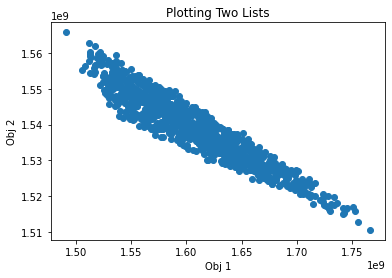

In [66]:
import matplotlib.pyplot as plt

# Two example lists to plot

# Plot the lists
plt.scatter(obj1_list, obj2_list)

# Add labels to the plot
plt.xlabel('Obj 1')
plt.ylabel('Obj 2')
plt.title('Plotting Two Lists')

# Display the plot
plt.show()
